# Bayesian MLP for MNIST using preconditioned SGLD

We use the [Jax Bayes](https://github.com/jamesvuc/jax-bayes) library 
by  James Vuckovic 
to fit an MLP to MNIST using SGD, and SGLD (with RMS preconditioning).
Code is based on:



1.   https://github.com/jamesvuc/jax-bayes/blob/master/examples/deep/mnist/mnist.ipynb
2.   https://github.com/jamesvuc/jax-bayes/blob/master/examples/deep/mnist/mnist_mcmc.ipynb


# Setup

In [1]:
%%capture
!pip install git+https://github.com/deepmind/dm-haiku
!pip install git+https://github.com/jamesvuc/jax-bayes

In [2]:
import haiku as hk

import jax.numpy as jnp
from jax.experimental import optimizers
import jax

import jax_bayes

import sys, os, math, time
import numpy as onp
import numpy as np
from functools import partial
from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow_datasets as tfds

# Data

In [3]:
def load_dataset(split, is_training, batch_size):
    ds = tfds.load("mnist:3.*.*", split=split).cache().repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    # return tfds.as_numpy(ds)
    return iter(tfds.as_numpy(ds))

In [4]:
# load the data into memory and create batch iterators
train_batches = load_dataset("train", is_training=True, batch_size=1_000)
val_batches = load_dataset("train", is_training=False, batch_size=10_000)
test_batches = load_dataset("test", is_training=False, batch_size=10_000)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model

In [5]:
nclasses = 10


def net_fn(batch, sig):
    """Standard LeNet-300-100 MLP"""
    x = batch["image"].astype(jnp.float32) / 255.0
    # x has size (1000, 28, 28, 1)
    D = np.prod(x.shape[1:])  # 784
    # To match initialization of linear layer
    # sigma = 1/sqrt(fan-in)
    # https://dm-haiku.readthedocs.io/en/latest/api.html#id1
    # w_init = hk.initializers.TruncatedNormal(stddev=stddev)
    sizes = [D, 300, 100, nclasses]
    sigmas = [sig / jnp.sqrt(fanin) for fanin in sizes]
    mlp = hk.Sequential(
        [
            hk.Flatten(),
            hk.Linear(sizes[1], w_init=hk.initializers.TruncatedNormal(stddev=sigmas[0]), b_init=jnp.zeros),
            jax.nn.relu,
            hk.Linear(sizes[2], w_init=hk.initializers.TruncatedNormal(stddev=sigmas[1]), b_init=jnp.zeros),
            jax.nn.relu,
            hk.Linear(sizes[3], w_init=hk.initializers.TruncatedNormal(stddev=sigmas[2]), b_init=jnp.zeros),
        ]
    )

    return mlp(x)


# L2 regularizer will be added to loss
reg = 1e-4

# SGD

In [6]:
net = hk.transform(partial(net_fn, sig=1))

lr = 1e-3
opt_init, opt_update, opt_get_params = optimizers.rmsprop(lr)

# instantiate the model parameters --- requires a sample batch to get size
params_init = net.init(jax.random.PRNGKey(42), next(train_batches))

# intialize the optimzier state
opt_state = opt_init(params_init)


def loss(params, batch):
    logits = net.apply(params, None, batch)
    labels = jax.nn.one_hot(batch["label"], 10)

    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

    softmax_crossent = -jnp.mean(labels * jax.nn.log_softmax(logits))

    return softmax_crossent + reg * l2_loss


@jax.jit
def accuracy(params, batch):
    preds = net.apply(params, None, batch)
    return jnp.mean(jnp.argmax(preds, axis=-1) == batch["label"])


@jax.jit
def train_step(i, opt_state, batch):
    params = opt_get_params(opt_state)
    dx = jax.grad(loss)(params, batch)
    opt_state = opt_update(i, dx, opt_state)
    return opt_state

In [7]:
print(params_init["linear"]["w"].shape)

(784, 300)


In [8]:
def callback(step, params, train_eval, test_eval, print_every=500):
    if step % print_every == 0:
        # Periodically evaluate classification accuracy on train & test sets.
        train_accuracy = accuracy(params, next(train_eval))
        test_accuracy = accuracy(params, next(test_eval))
        train_accuracy, test_accuracy = jax.device_get((train_accuracy, test_accuracy))
        print(f"[Step {step}] Train / Test accuracy: " f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

In [9]:
%%time

nsteps = 5000
for step in range(nsteps + 1):
    opt_state = train_step(step, opt_state, next(train_batches))
    params_sgd = opt_get_params(opt_state)
    callback(step, params_sgd, val_batches, test_batches)

[Step 0] Train / Test accuracy: 0.362 / 0.368.
[Step 500] Train / Test accuracy: 0.971 / 0.963.
[Step 1000] Train / Test accuracy: 0.985 / 0.977.
[Step 1500] Train / Test accuracy: 0.986 / 0.977.
[Step 2000] Train / Test accuracy: 0.989 / 0.980.
[Step 2500] Train / Test accuracy: 0.992 / 0.981.
[Step 3000] Train / Test accuracy: 0.995 / 0.981.
[Step 3500] Train / Test accuracy: 0.991 / 0.973.
[Step 4000] Train / Test accuracy: 0.994 / 0.981.
[Step 4500] Train / Test accuracy: 0.996 / 0.982.
[Step 5000] Train / Test accuracy: 0.994 / 0.981.
CPU times: user 30.9 s, sys: 6.12 s, total: 37 s
Wall time: 22.9 s


# SGLD

In [10]:
lr = 5e-3

num_samples = 10  # number of samples to approximate the posterior
init_stddev = 0.01  # 0.1 # params sampled around params_init

# we initialize all weights to 0 since we will be sampling them anyway
# net_bayes = hk.transform(partial(net_fn, sig=0))

sampler_fns = jax_bayes.mcmc.rms_langevin_fns
seed = 0
key = jax.random.PRNGKey(seed)
sampler_init, sampler_propose, sampler_update, sampler_get_params = sampler_fns(
    key, num_samples=num_samples, step_size=lr, init_stddev=init_stddev
)

In [11]:
@jax.jit
def accuracy_bayes(params_samples, batch):
    # average the logits over the parameter samples
    pred_fn = jax.vmap(net.apply, in_axes=(0, None, None))
    preds = jnp.mean(pred_fn(params_samples, None, batch), axis=0)
    return jnp.mean(jnp.argmax(preds, axis=-1) == batch["label"])


# the log-probability is the negative of the loss
logprob = lambda p, b: -loss(p, b)

# build the mcmc step. This is like the opimization step, but for sampling
@jax.jit
def mcmc_step(i, sampler_state, sampler_keys, batch):
    # extract parameters
    params = sampler_get_params(sampler_state)

    # form a partial eval of logprob on the data
    logp = lambda p: logprob(p, batch)

    # evaluate *per-sample* gradients
    fx, dx = jax.vmap(jax.value_and_grad(logp))(params)

    # generat proposal states for the Markov chains
    sampler_prop_state, new_keys = sampler_propose(i, dx, sampler_state, sampler_keys)

    # we don't need to re-compute gradients for the accept stage (unadjusted Langevin)
    fx_prop, dx_prop = fx, dx

    # accept the proposal states for the markov chain
    sampler_state, new_keys = sampler_update(i, fx, fx_prop, dx, sampler_state, dx_prop, sampler_prop_state, new_keys)

    return jnp.mean(fx), sampler_state, new_keys

In [12]:
def callback_bayes(step, params, val_batches, test_batches, print_every=500):
    if step % print_every == 0:
        val_acc = accuracy_bayes(params, next(val_batches))
        test_acc = accuracy_bayes(params, next(test_batches))
        print(f"step = {step}" f" | val acc = {val_acc:.3f}" f" | test acc = {test_acc:.3f}")

In [13]:

%%time

#get a single sample of the params using the normal hk.init(...)
params_init = net.init(jax.random.PRNGKey(42), next(train_batches))

# get a SamplerState object with `num_samples` params along dimension 0
# generated by adding Gaussian noise (see sampler_fns(..., init_dist='normal'))
sampler_state, sampler_keys = sampler_init(params_init)

# iterate the the Markov chain
nsteps = 5000
for step in range(nsteps+1):
  train_logprob, sampler_state, sampler_keys = \
    mcmc_step(step, sampler_state, sampler_keys, next(train_batches))
  params_samples = sampler_get_params(sampler_state)
  callback_bayes(step, params_samples, val_batches, test_batches)


step = 0 | val acc = 0.060 | test acc = 0.057
step = 500 | val acc = 0.512 | test acc = 0.526
step = 1000 | val acc = 0.806 | test acc = 0.803
step = 1500 | val acc = 0.869 | test acc = 0.875
step = 2000 | val acc = 0.902 | test acc = 0.907
step = 2500 | val acc = 0.917 | test acc = 0.921
step = 3000 | val acc = 0.930 | test acc = 0.929
step = 3500 | val acc = 0.940 | test acc = 0.938
step = 4000 | val acc = 0.944 | test acc = 0.941
step = 4500 | val acc = 0.947 | test acc = 0.944
step = 5000 | val acc = 0.952 | test acc = 0.946
CPU times: user 24.6 s, sys: 1.34 s, total: 25.9 s
Wall time: 23.3 s


In [14]:
print(params_samples["linear"]["w"].shape)  # 10 samples of the weights for first layer

(10, 784, 300)


# Uncertainty analysis

We select the predictions above a confidence threshold, and compute the predictive accuracy on that subset. As we increase the threshold, the accuracy should increase, but fewer examples will be selected.

In [15]:
test_batch = next(test_batches)
from jax_bayes.utils import entropy, certainty_acc

In [16]:
def plot_acc_vs_confidence(predict_fn, test_batch):
    # plot how accuracy changes as we increase the required level of certainty
    preds = predict_fn(test_batch)  # (batch_size, n_classes) array of probabilities
    acc, mask = certainty_acc(preds, test_batch["label"], cert_threshold=0)
    thresholds = [0.1 * i for i in range(11)]
    cert_accs, pct_certs = [], []
    for t in thresholds:
        cert_acc, cert_mask = certainty_acc(preds, test_batch["label"], cert_threshold=t)
        cert_accs.append(cert_acc)
        pct_certs.append(cert_mask.mean())

    fig, ax = plt.subplots(1)
    line1 = ax.plot(thresholds, cert_accs, label="accuracy at certainty", marker="x")
    line2 = ax.axhline(y=acc, label="regular accuracy", color="black")
    ax.set_ylabel("accuracy")
    ax.set_xlabel("certainty threshold")

    axb = ax.twinx()
    line3 = axb.plot(thresholds, pct_certs, label="pct of certain preds", color="green", marker="x")
    axb.set_ylabel("pct certain")

    lines = line1 + [line2] + line3
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=6)

    return fig, ax

## SGD

For the plugin estimate, the model is very confident on nearly all of the points.

In [17]:
# plugin approximation to  posterior predictive
@jax.jit
def posterior_predictive_plugin(params, batch):
    logit_pp = net.apply(params, None, batch)
    return jax.nn.softmax(logit_pp, axis=-1)

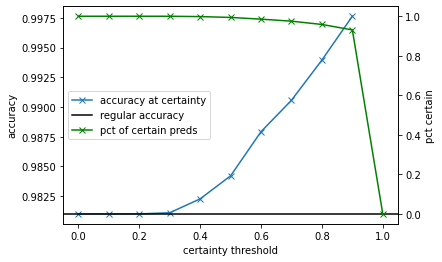

In [18]:
def pred_fn(batch):
    return posterior_predictive_plugin(params_sgd, batch)


fig, ax = plot_acc_vs_confidence(pred_fn, test_batch)
plt.savefig("acc-vs-conf-sgd.pdf")
plt.show()

## SGLD

In [19]:
def posterior_predictive_bayes(params_sampled, batch):
    """computes the posterior_predictive P(class = c | inputs, params) using a histogram"""
    pred_fn = lambda p: net.apply(p, jax.random.PRNGKey(0), batch)
    pred_fn = jax.vmap(pred_fn)

    logit_samples = pred_fn(params_sampled)  # n_samples x batch_size x n_classes
    pred_samples = jnp.argmax(logit_samples, axis=-1)  # n_samples x batch_size

    n_classes = logit_samples.shape[-1]
    batch_size = logit_samples.shape[1]
    probs = np.zeros((batch_size, n_classes))
    for c in range(n_classes):
        idxs = pred_samples == c
        probs[:, c] = idxs.sum(axis=0)

    return probs / probs.sum(axis=1, keepdims=True)

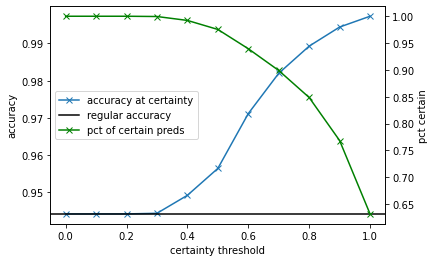

In [20]:
def pred_fn(batch):
    return posterior_predictive_bayes(params_samples, batch)


fig, ax = plot_acc_vs_confidence(pred_fn, test_batch)
plt.savefig("acc-vs-conf-sgld.pdf")
plt.show()

# Distribution shift

We now examine the behavior of the models on the Fashion MNIST dataset.
We expect the predictions to be much less confident, since the inputs are now 'out of distribution'. We will see that this is true for the Bayesian approach, but not for the plugin approximation. 

In [21]:
fashion_ds = tfds.load("fashion_mnist:3.*.*", split="test").cache().repeat()
fashion_test_batches = tfds.as_numpy(fashion_ds.batch(10_000))
fashion_test_batches = iter(fashion_test_batches)

fashion_batch = next(fashion_test_batches)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOGMZ6W/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOGMZ6W/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## SGD

We see that the plugin estimate is confident (but wrong!) on many of the predictions, which is undesirable.
If consider a confidence threshold of 0.6, 
the plugin approach predicts on about 80% of the examples,
even though the accuracy is only about 6% on these.

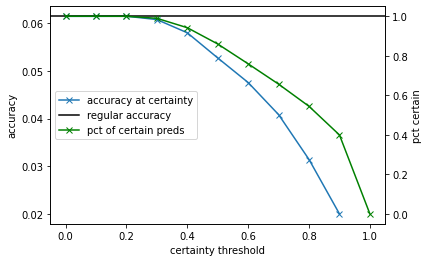

In [22]:
def pred_fn(batch):
    return posterior_predictive_plugin(params_sgd, batch)


fig, ax = plot_acc_vs_confidence(pred_fn, fashion_batch)
plt.savefig("acc-vs-conf-sgd-fashion.pdf")
plt.show()

## SGLD

If consider a confidence threshold of 0.6, 
the Bayesian approach predicts on less than 20% of the examples,
on which the accuracy is ~4%.


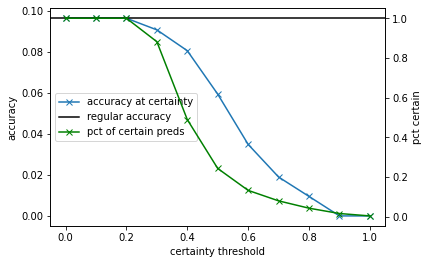

In [23]:
def pred_fn(batch):
    return posterior_predictive_bayes(params_samples, batch)


fig, ax = plot_acc_vs_confidence(pred_fn, fashion_batch)
plt.savefig("acc-vs-conf-sgld-fashion.pdf")
plt.show()